In [3]:
import pandas as pd 
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [5]:
weather_data = pd.read_csv('weather_data.csv')
demand_data = pd.read_csv('demand_data.csv')

In [21]:
#Define Ststem Parameters
#System Constraints
COST_SOLAR = 0.12  #Cost in dollars per kWh
COST_WIND = 0.10   #Cost in dollars per kWh
COST_STORAGE = 0.05 # Cost in dollars per kWh

MAX_SOLAR_CAPACITY = 100 #Capacity in kWh
MAX_WIND_CAPACITY = 150  #Capacity in kWh
STORAGE_CAPACITY = 200        #Capacity in kWh

#Solar Production Model
def solar_production(irradiance, efficiency =0.2):
    solar_output = irradiance * MAX_SOLAR_CAPACITY * efficiency
    return solar_output

#Wind Production model
def wind_production(wind_speed, efficiency= 0.3):
    base_output = wind_speed * MAX_WIND_CAPACITY * efficiency
    adjusted_output = np.where(
        wind_speed < 10,
        base_output * 0.5,
        base_output
    )
    return adjusted_output

    

In [29]:
# Define the Objective Function for optimization
DEMAND = demand_data['energy_demand'].values

def total_cost(x):
    solar_energy = solar_production(
        weather_data['solar_irradiance'].values,
        x[0]
    )
    wind_energy = wind_production(
        weather_data['wind_speed'].values,
        x[1]
    )
    storage_usage = [2] * STORAGE_CAPACITY
    # Ensure storage usage matches the length of solar_energy and wind_energy
    storage_usage = np.full_like(solar_energy, 2)  # or adjust as needed
    
    
    total_energy = solar_energy + wind_energy + storage_usage
    
    # Calculate energy deficit
    energy_deficit = DEMAND - total_energy
    
    # Ensure no negative deficits
    energy_deficit = energy_deficit.clip(min=0)
    
    cost = (
        solar_energy * COST_SOLAR +
        wind_energy * COST_WIND +
        storage_usage * COST_STORAGE +
        energy_deficit * 0.15
    ).sum()
    
    return cost


In [31]:
#Optimize the System Configuration
x0 = [0.2, 0.3, 0.5]
bounds = [(0.1, 0.3), (0.2, 0.4), (0, 1)]
result = minimize(
    total_cost, x0, bounds=bounds, method='TNC'
)

In [45]:
#Optimizing Renewable Energy Production and storage
#Generate Dates for January 2023
date = pd.date_range(start = '2023-01-01',
                     end = '2023-01-31',
                     freq ='D'
                    )
#Calculate optimized solar energy
optimized_solar_energy = solar_production(
    weather_data['solar_irradiance'], result.x[0])
#Calculate optimized wind energy
optimized_wind_energy = wind_production(
    weather_data['wind_speed'], result.x[1])

#Calculate optimized stoarge
optimized_storage_usage = result.x[2] * STORAGE_CAPACITY


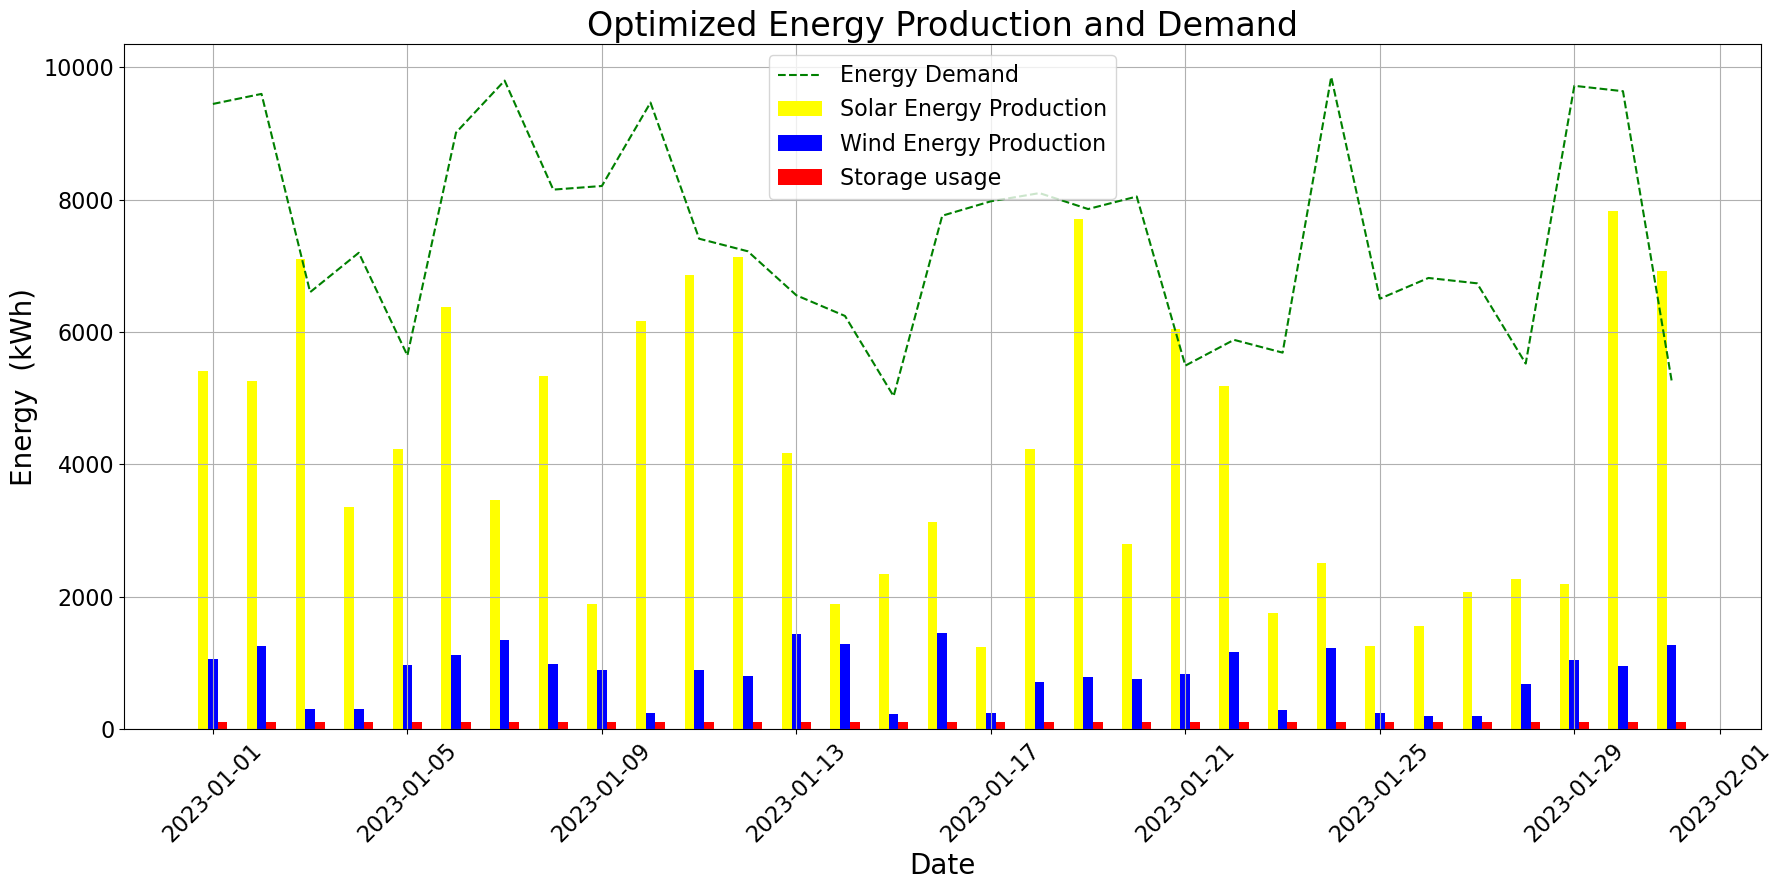

In [49]:
#Visualize results
#Generate the dates for the x-axis
date = pd.date_range(start = '2023-01-01', end = '2023-01-31', freq = 'D')

#Initialize the figure with a specific size
fig, ax = plt.subplots(figsize =(18,9))
#Define the width of the bars 
width = 0.2

#Plot each energy with appropriate offsets for clarity
ax.bar(date - pd.Timedelta(days=width), optimized_solar_energy, width, label='Solar Energy Production', color ='yellow')

ax.bar(date, optimized_wind_energy, width, label='Wind Energy Production', color ='blue')

ax.bar(date + pd.Timedelta(days=width), optimized_storage_usage, width, label='Storage usage', color='red')


#Plot the energy demand as a line chart for comparison
ax.plot(date, DEMAND, 'g--', label='Energy Demand')

#Set the titles and labels with increased font sizes for clarity
ax.set_title('Optimized Energy Production and Demand', fontsize=24)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Energy  (kWh)', fontsize=20)

#Rotate the x-axis tick labels for better readability
ax.tick_params(axis= 'x', rotation=45, labelsize=16)
ax.tick_params(axis='y', labelsize =16)

#Add Legend
ax.legend(fontsize=16)

#Enable grid for better readabily of the plot
ax.grid(True)

#Adjust layout to make room for the tick labels
plt.tight_layout()

#Display the plot
plt.show()

